# Credit Risk Resampling Techniques

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from imblearn.metrics import classification_report_imbalanced

# Read the CSV and Perform Basic Data Cleaning

In [3]:
columns = [
    "loan_amnt", "int_rate", "installment", "home_ownership",
    "annual_inc", "verification_status", "issue_d", "loan_status",
    "pymnt_plan", "dti", "delinq_2yrs", "inq_last_6mths",
    "open_acc", "pub_rec", "revol_bal", "total_acc",
    "initial_list_status", "out_prncp", "out_prncp_inv", "total_pymnt",
    "total_pymnt_inv", "total_rec_prncp", "total_rec_int", "total_rec_late_fee",
    "recoveries", "collection_recovery_fee", "last_pymnt_amnt", "next_pymnt_d",
    "collections_12_mths_ex_med", "policy_code", "application_type", "acc_now_delinq",
    "tot_coll_amt", "tot_cur_bal", "open_acc_6m", "open_act_il",
    "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il",
    "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc",
    "all_util", "total_rev_hi_lim", "inq_fi", "total_cu_tl",
    "inq_last_12m", "acc_open_past_24mths", "avg_cur_bal", "bc_open_to_buy",
    "bc_util", "chargeoff_within_12_mths", "delinq_amnt", "mo_sin_old_il_acct",
    "mo_sin_old_rev_tl_op", "mo_sin_rcnt_rev_tl_op", "mo_sin_rcnt_tl", "mort_acc",
    "mths_since_recent_bc", "mths_since_recent_inq", "num_accts_ever_120_pd", "num_actv_bc_tl",
    "num_actv_rev_tl", "num_bc_sats", "num_bc_tl", "num_il_tl",
    "num_op_rev_tl", "num_rev_accts", "num_rev_tl_bal_gt_0",
    "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd", "num_tl_90g_dpd_24m",
    "num_tl_op_past_12m", "pct_tl_nvr_dlq", "percent_bc_gt_75", "pub_rec_bankruptcies",
    "tax_liens", "tot_hi_cred_lim", "total_bal_ex_mort", "total_bc_limit",
    "total_il_high_credit_limit", "hardship_flag", "debt_settlement_flag"
]

target = ["loan_status"]

In [4]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path, skiprows=1)[:-2]
df = df.loc[:, columns].copy()

# Drop the null columns where all values are null
df = df.dropna(axis='columns', how='all')

# Drop the null rows
df = df.dropna()

# Remove the `Issued` loan status
issued_mask = df['loan_status'] != 'Issued'
df = df.loc[issued_mask]

# convert interest rate to numerical
df['int_rate'] = df['int_rate'].str.replace('%', '')
df['int_rate'] = df['int_rate'].astype('float') / 100


# Convert the target column values to low_risk and high_risk based on their values
x = {'Current': 'low_risk'}   
df = df.replace(x)

x = dict.fromkeys(['Late (31-120 days)', 'Late (16-30 days)', 'Default', 'In Grace Period'], 'high_risk')    
df = df.replace(x)

df.reset_index(inplace=True, drop=True)

df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


# Split the Data into Training and Testing

In [5]:
# Create our features
X = df.drop("loan_status", axis=1)
X = pd.get_dummies(X)

# Create our target
y = df.loc[:, target].copy()

In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.383161,0.616839,0.860340,0.139660,1.0,1.0
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.486161,0.486161,0.346637,0.346637,0.0,0.0
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,1.0
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0,1.0
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0


In [7]:
# Check the balance of our target values
y['loan_status'].value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=1)

# Oversampling

In this section, you will compare two oversampling algorithms to determine which algorithm results in the best performance. You will oversample the data using the naive random oversampling algorithm and the SMOTE algorithm. For each algorithm, be sure to complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

### Naive Random Oversampling

In [9]:
# Resample the training data with the RandomOversampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

Counter(y_resampled)

Counter({'loan_status': 1})

In [10]:
# Train the Logistic Regression model using the resampled data
# Logistic regression using random oversampled data
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [11]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
acc_score = balanced_accuracy_score(y_test, y_pred)
acc_score

0.6383950485787587

In [12]:
# Display the confusion matrix
from sklearn.metrics import confusion_matrix ,accuracy_score, classification_report
y_pred = model.predict(X_test)
# confusion_matrix(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)

# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,67,34
Actual 1,6612,10492


In [13]:

# Print the imbalanced classification report
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,67,34
Actual 1,6612,10492


Accuracy Score : 0.6383950485787587
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.66      0.61      0.02      0.64      0.41       101
   low_risk       1.00      0.61      0.66      0.76      0.64      0.40     17104

avg / total       0.99      0.61      0.66      0.76      0.64      0.40     17205



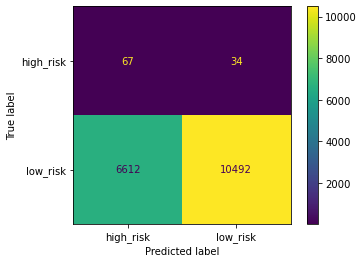

In [14]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmat = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat,
                               display_labels=model.classes_)
disp.plot( values_format='')
plt.show()

### SMOTE Oversampling

In [15]:
# Resample the training data with SMOTE
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE(random_state=1,
sampling_strategy='auto').fit_resample(
   X_train, y_train)
Counter(y_resampled)


Counter({'loan_status': 1})

In [16]:
# Check the balance of our target values
y_resampled['loan_status'].value_counts()

low_risk     51366
high_risk    51366
Name: loan_status, dtype: int64

In [17]:
# Train the Logistic Regression model using the resampled data
smote_model = LogisticRegression(solver='lbfgs', random_state=1)
smote_model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [18]:
# Calculated the balanced accuracy score
from sklearn.metrics import confusion_matrix ,accuracy_score 
from imblearn.metrics import classification_report_imbalanced
y_pred = smote_model.predict(X_test)
sm_acc_score = balanced_accuracy_score(y_test, y_pred)
sm_acc_score


0.6589052760514592

In [19]:
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,63,38
Actual 1,5233,11871


In [20]:
# Print the imbalanced classification report
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {sm_acc_score}")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,63,38
Actual 1,5233,11871


Accuracy Score : 0.6589052760514592
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.62      0.69      0.02      0.66      0.43       101
   low_risk       1.00      0.69      0.62      0.82      0.66      0.44     17104

avg / total       0.99      0.69      0.62      0.81      0.66      0.44     17205



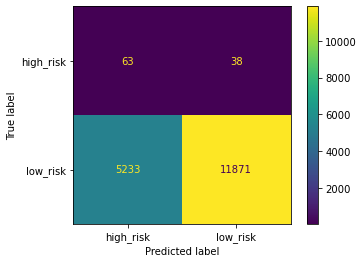

In [21]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmat = confusion_matrix(y_test, y_pred, labels=smote_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat,
                               display_labels=smote_model.classes_)
disp.plot( values_format='')
plt.show()

# Undersampling

In this section, you will test an undersampling algorithms to determine which algorithm results in the best performance compared to the oversampling algorithms above. You will undersample the data using the Cluster Centroids algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [22]:
# Resample the data using the ClusterCentroids resampler
from imblearn.under_sampling import ClusterCentroids
ros = ClusterCentroids(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)

Counter({'loan_status': 1})

In [23]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [24]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
acc_score = balanced_accuracy_score(y_test, y_pred)
acc_score

0.5447339051023905

In [25]:
# Display the confusion matrix

cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,70,31
Actual 1,10324,6780


In [26]:
# Print the imbalanced classification report
from imblearn.metrics import classification_report_imbalanced
# print(classification_report_imbalanced(y_test, y_pred))
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,70,31
Actual 1,10324,6780


Accuracy Score : 0.5447339051023905
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.69      0.40      0.01      0.52      0.28       101
   low_risk       1.00      0.40      0.69      0.57      0.52      0.27     17104

avg / total       0.99      0.40      0.69      0.56      0.52      0.27     17205



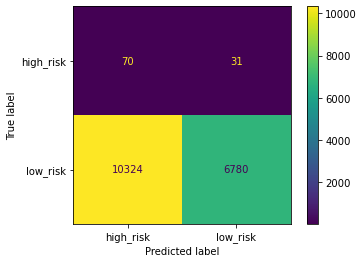

In [27]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmat = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat,
                               display_labels=model.classes_)
disp.plot( values_format='')
plt.show()

# Combination (Over and Under) Sampling

In this section, you will test a combination over- and under-sampling algorithm to determine if the algorithm results in the best performance compared to the other sampling algorithms above. You will resample the data using the SMOTEENN algorithm and complete the folliowing steps:

1. View the count of the target classes using `Counter` from the collections library. 
3. Use the resampled data to train a logistic regression model.
3. Calculate the balanced accuracy score from sklearn.metrics.
4. Print the confusion matrix from sklearn.metrics.
5. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.

Note: Use a random state of 1 for each sampling algorithm to ensure consistency between tests

In [28]:
# Resample the training data with SMOTEENN
# Warning: This is a large dataset, and this step may take some time to complete
from imblearn.combine import SMOTEENN
X_resampled, y_resampled = SMOTEENN(random_state=1,
sampling_strategy='auto').fit_resample(
   X, y)
Counter(y_resampled)

Counter({'loan_status': 1})

In [29]:
# Train the Logistic Regression model using the resampled data
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs', random_state=1)
model.fit(X_resampled, y_resampled)

LogisticRegression(random_state=1)

In [30]:
# Calculated the balanced accuracy score
from sklearn.metrics import balanced_accuracy_score
y_pred = model.predict(X_test)
acc_score=balanced_accuracy_score(y_test, y_pred)
acc_score

0.6668242157471126

In [31]:
# Display the confusion matrix
# Display the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"],
    columns=["Predicted 0", "Predicted 1"]
)
# Displaying results
display(cm_df)

,Predicted 0,Predicted 1
Actual 0,80,21
Actual 1,7841,9263


In [32]:
# Print the imbalanced classification report
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report_imbalanced(y_test, y_pred))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,80,21
Actual 1,7841,9263


Accuracy Score : 0.6668242157471126
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.01      0.79      0.54      0.02      0.65      0.44       101
   low_risk       1.00      0.54      0.79      0.70      0.65      0.42     17104

avg / total       0.99      0.54      0.79      0.70      0.65      0.42     17205



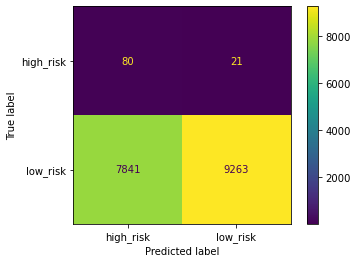

In [33]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cmat = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cmat,
                               display_labels=model.classes_)
disp.plot( values_format='')
plt.show()